In [1]:
#Import the basic libraries
import os
import pandas as pd
import numpy as np

#from sklearn.preprocessing import Scaler Methods
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold

import matplotlib.pyplot as plt 
from matplotlib import cm
import itertools
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

from sklearn import datasets, metrics
from numpy import nan as NaN

In [2]:
# import pairs
labelled_pairs = pd.read_csv('../dataset_generation_and_featurization/ground_truth_pairs.csv', index_col=0)
unlabelled_pairs = pd.read_csv('../dataset_generation_and_featurization/query_pairs.csv', index_col=0)

In [3]:
import pickle
with open('../dataset_generation_and_featurization/linker_list.pkl','rb') as f:
    linker_list = pickle.load(f)
print(len(linker_list)) 

import rdkit
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.Chem import AllChem

# produce features for linker_list
def morgan_fpts_dl(data):
    Morgan_fpts = []
    for i in data:
        mol = Chem.MolFromSmiles(i)
        fpts = AllChem.GetMorganFingerprintAsBitVect(mol,2,256)
        mfpts = np.array(fpts)
        Morgan_fpts.append(mfpts)
    return np.array(Morgan_fpts)

Morgan_fpts_dl = morgan_fpts_dl(linker_list)
linker_df = pd.DataFrame(Morgan_fpts_dl, index=linker_list, columns=['Col_{}'.format(i) for i in range(Morgan_fpts_dl.shape[1])])

3169


In [4]:
metal_minmax = pd.read_csv('../dataset_generation_and_featurization/metal_scaled_205.csv',index_col=0)
linker_minmax = linker_df

# generate full data vector
# labelled
metal_data= list()
for metal in labelled_pairs['metal']:
    metal_data.append(metal_minmax.loc[metal,:])    
metal_data = pd.DataFrame(metal_data, index=np.arange(len(labelled_pairs['metal'])), columns = metal_minmax.columns.values)
linker_data= list()
for linker in labelled_pairs['linker_SMILES']:   
    linker_data.append(linker_minmax.loc[linker,:])
linker_data = pd.DataFrame(linker_data, index=np.arange(len(labelled_pairs['metal'])), columns= linker_minmax.columns.values)
labelled_df = pd.concat([labelled_pairs, metal_data, linker_data], axis = 1)
#unlabelled
metal_data= list()
for metal in unlabelled_pairs['metal']:
    metal_data.append(metal_minmax.loc[metal,:])    
metal_data = pd.DataFrame(metal_data, index=np.arange(len(unlabelled_pairs['metal'])), columns = metal_minmax.columns.values)
linker_data= list()
for linker in unlabelled_pairs['linker_SMILES']:   
    linker_data.append(linker_minmax.loc[linker,:])
linker_data = pd.DataFrame(linker_data, index=np.arange(len(unlabelled_pairs['metal'])), columns= linker_minmax.columns.values)
unlabelled_df = pd.concat([unlabelled_pairs, metal_data, linker_data], axis = 1)

In [5]:
from pyod.models.iforest import IForest
from pyod.models.knn import KNN
from pyod.models.lof import LOF
from pyod.models.ocsvm import OCSVM
from pyod.models.cblof import CBLOF

MinMax_scaler = preprocessing.MinMaxScaler()

def fit_predict(clf, X_train, X_val, X_test):
    
    train_scores = []
    test_scores = []
    clf.fit(X_train)

    train_scores = clf.decision_function(X_train) # higher score means outliers
    test_scores = clf.decision_function(X_test)
    val_scores = clf.decision_function(X_val)
    train_scores = train_scores *(-1)  # higher score means inliers
    test_scores = test_scores *(-1)
    val_scores = val_scores *(-1)

    return train_scores, val_scores, test_scores

def mfd_ot(train_scores, test_scores):
    
    iter_num = np.linspace(0.0,1.0,num=101)
    train_fraction = []
    test_fraction = []
    single_eval = []

    for i in iter_num:
        threshold = i
        train_count_inlier = np.sum(train_scores >= threshold)
        test_count_inlier = np.sum(test_scores[:] >= threshold)
        train_percent = train_count_inlier/len(train_scores)
        test_percent = test_count_inlier/len(test_scores)
        single = train_percent - test_percent
        train_fraction.append(train_percent)
        test_fraction.append(test_percent)
        single_eval.append(single)

    # extreme point
    single_max = max(single_eval)
    temp = single_eval.index(single_max)
    threshold_max = iter_num[temp]
    
    return threshold_max, single_max

def cross_val(clf_name, clf):
    
    ot_list =[]
    mfd_list = []
    
    train_scores_df = pd.DataFrame()
    val_scores_df = pd.DataFrame()
    test_scores_df = pd.DataFrame()
    
    tp_list = []
    
    X_train= labelled_df.iloc[:, 2:]
    X_train_val=pd.concat([pd.DataFrame(X_train.values), pd.DataFrame(np.ones(len(X_train)))], axis=1)
    X_test = unlabelled_df.iloc[:, 2:]

    # Perform k-fold cross validation

    kf = KFold(n_splits = 5, shuffle = True, random_state = 42)
    kf.get_n_splits(X_train_val)

    for train, val in kf.split(X_train_val):
        
        # make predictions
        train_data = np.array(X_train_val)[train]
        train_label = train_data[:,-1]
        val_data = np.array(X_train_val)[val]
        val_label = val_data[:,-1]
        
        train_result, val_result, test_result = fit_predict(clf, train_data[:,:-1], val_data[:,:-1], X_test)
        
        # concate result
        train_scores_df.insert(train_scores_df.shape[1],column=train_scores_df.shape[1],value=train_result)
        val_scores_df.insert(val_scores_df.shape[1],column=val_scores_df.shape[1],value=val_result)
        test_scores_df.insert(test_scores_df.shape[1],column=test_scores_df.shape[1],value=test_result)
        
        # calculate MFD & OT
        scores_range = np.concatenate((np.array(train_result),np.array(test_result))).reshape(-1,1)
        scores_scaler = MinMax_scaler.fit(scores_range)
        train_scores = scores_scaler.transform(np.array(train_result).reshape(-1,1))
        val_scores = scores_scaler.transform(np.array(val_result).reshape(-1,1))
        test_scores = scores_scaler.transform(np.array(test_result).reshape(-1,1))
        
        ot, mfd = mfd_ot(train_scores, test_scores)
        
        # concate ot&mfd
        ot_list.append(ot)
        mfd_list.append(mfd)
        
        # calculate accuracy use val data and ot
        pred_val = np.sum(val_scores >= ot)
        tp = pred_val/len(val_scores)
        print(len(val_scores))
        tp_list.append(tp)

    # save result
    path_name = 'result/deviation_split_best/'+clf_name+'_train.csv'
    os.makedirs(os.path.dirname(path_name), exist_ok=True)
    train_scores_df.to_csv(path_name)
    path_name = 'result/deviation_split_best/'+clf_name+'_val.csv'
    os.makedirs(os.path.dirname(path_name), exist_ok=True)
    val_scores_df.to_csv(path_name)
    path_name = 'result/deviation_split_best/'+clf_name+'_test.csv'
    os.makedirs(os.path.dirname(path_name), exist_ok=True)
    test_scores_df.to_csv(path_name)
            
    return ot_list, mfd_list, tp_list

In [6]:
classifiers = {
    'IForest': 
        IForest(behaviour="new", bootstrap=False, contamination=0.1, n_estimators=300,  max_features=1.0, max_samples=1000, random_state=None), 
    'KNN': 
        KNN(contamination=0.1, method='mean', n_neighbors=150, metric='minkowski', algorithm='auto'),    
    'OCSVM': 
        OCSVM(contamination=0.1, kernel='rbf' , nu= 0.8, degree=10, gamma='auto', shrinking=True, tol=0.001, cache_size=200), 
    'LOF':
        LOF(algorithm='auto', n_neighbors=27, contamination=0.1, novelty=True, metric='minkowski'), 
    'CBLOF':    
        CBLOF(contamination=0.1, alpha=0.6, beta=2, n_clusters=32, n_jobs=None),
}


for key, value in classifiers.items():
      locals()['ot_'+key], locals()['mfd_'+key], locals()['tp_'+key] = cross_val(key, value)


1475
1475
1475
1475
1475
1475
1475
1475
1475
1475
1475
1475
1475
1475
1475
1475
1475
1475
1475
1475
1475
1475
1475
1475
1475


In [7]:
# train LUNAR model
%cd ../model_architecture/

from pyod_modi.models.lunar_2 import LUNAR
clf = LUNAR(verbose=1, n_epochs=100)

%cd ../model_validation_and_analysis/

ot_LUNAR, mfd_LUNAR, tp_LUNAR = cross_val('LUNAR', clf)

C:\Users\zhangchi\Project_and_Git\Upload\MOF_synthesisability_prediction\model_architecture
C:\Users\zhangchi\Project_and_Git\Upload\MOF_synthesisability_prediction\model_validation_and_analysis
Epoch 0 	 Train Score 0.549233 	 Val Score 0.794872
Epoch 1 	 Train Score 0.656765 	 Val Score 0.793338
Epoch 2 	 Train Score 0.69515 	 Val Score 0.792465
Epoch 3 	 Train Score 0.701528 	 Val Score 0.792821
Epoch 4 	 Train Score 0.702805 	 Val Score 0.792804
Epoch 5 	 Train Score 0.703212 	 Val Score 0.792945
Epoch 6 	 Train Score 0.703441 	 Val Score 0.793016
Epoch 7 	 Train Score 0.70355 	 Val Score 0.792976
Epoch 8 	 Train Score 0.703621 	 Val Score 0.792969
Epoch 9 	 Train Score 0.703684 	 Val Score 0.792988
Epoch 10 	 Train Score 0.70373 	 Val Score 0.792979
Epoch 11 	 Train Score 0.703758 	 Val Score 0.793002
Epoch 12 	 Train Score 0.703783 	 Val Score 0.793008
Epoch 13 	 Train Score 0.703801 	 Val Score 0.793022
Epoch 14 	 Train Score 0.703817 	 Val Score 0.793014
Epoch 15 	 Train Score 

Epoch 50 	 Train Score 0.858725 	 Val Score 0.782178
Epoch 51 	 Train Score 0.858923 	 Val Score 0.782063
Epoch 52 	 Train Score 0.858947 	 Val Score 0.78208
Epoch 53 	 Train Score 0.858975 	 Val Score 0.782212
Epoch 54 	 Train Score 0.85899 	 Val Score 0.782031
Epoch 55 	 Train Score 0.858987 	 Val Score 0.78202
Epoch 56 	 Train Score 0.858978 	 Val Score 0.782017
Epoch 57 	 Train Score 0.85893 	 Val Score 0.782017
Epoch 58 	 Train Score 0.858763 	 Val Score 0.782017
Epoch 59 	 Train Score 0.858541 	 Val Score 0.782017
Epoch 60 	 Train Score 0.858459 	 Val Score 0.782014
Epoch 61 	 Train Score 0.858576 	 Val Score 0.782014
Epoch 62 	 Train Score 0.858807 	 Val Score 0.782014
Epoch 63 	 Train Score 0.858908 	 Val Score 0.782014
Epoch 64 	 Train Score 0.858951 	 Val Score 0.782014
Epoch 65 	 Train Score 0.858957 	 Val Score 0.782014
Epoch 66 	 Train Score 0.858962 	 Val Score 0.782011
Epoch 67 	 Train Score 0.858964 	 Val Score 0.782011
Epoch 68 	 Train Score 0.858965 	 Val Score 0.7820

Epoch 3 	 Train Score 0.811497 	 Val Score 0.777966
Epoch 4 	 Train Score 0.803178 	 Val Score 0.778296
Epoch 5 	 Train Score 0.801905 	 Val Score 0.778604
Epoch 6 	 Train Score 0.805257 	 Val Score 0.778759
Epoch 7 	 Train Score 0.810434 	 Val Score 0.778923
Epoch 8 	 Train Score 0.81433 	 Val Score 0.779115
Epoch 9 	 Train Score 0.816348 	 Val Score 0.779647
Epoch 10 	 Train Score 0.819007 	 Val Score 0.779925
Epoch 11 	 Train Score 0.825799 	 Val Score 0.779759
Epoch 12 	 Train Score 0.835335 	 Val Score 0.778564
Epoch 13 	 Train Score 0.847022 	 Val Score 0.777308
Epoch 14 	 Train Score 0.85993 	 Val Score 0.777064
Epoch 15 	 Train Score 0.868654 	 Val Score 0.77686
Epoch 16 	 Train Score 0.872188 	 Val Score 0.77742
Epoch 17 	 Train Score 0.87292 	 Val Score 0.777041
Epoch 18 	 Train Score 0.873128 	 Val Score 0.776648
Epoch 19 	 Train Score 0.873234 	 Val Score 0.776662
Epoch 20 	 Train Score 0.873307 	 Val Score 0.776742
Epoch 21 	 Train Score 0.873416 	 Val Score 0.776788
Epoch

Epoch 58 	 Train Score 0.87555 	 Val Score 0.770988
Epoch 59 	 Train Score 0.875552 	 Val Score 0.770988
Epoch 60 	 Train Score 0.875555 	 Val Score 0.770991
Epoch 61 	 Train Score 0.875558 	 Val Score 0.770988
Epoch 62 	 Train Score 0.87556 	 Val Score 0.770988
Epoch 63 	 Train Score 0.875561 	 Val Score 0.770988
Epoch 64 	 Train Score 0.875562 	 Val Score 0.770988
Epoch 65 	 Train Score 0.875564 	 Val Score 0.770988
Epoch 66 	 Train Score 0.875564 	 Val Score 0.770988
Epoch 67 	 Train Score 0.875564 	 Val Score 0.770991
Epoch 68 	 Train Score 0.875565 	 Val Score 0.770994
Epoch 69 	 Train Score 0.875566 	 Val Score 0.770994
Epoch 70 	 Train Score 0.875568 	 Val Score 0.770994
Epoch 71 	 Train Score 0.875571 	 Val Score 0.770994
Epoch 72 	 Train Score 0.875574 	 Val Score 0.771
Epoch 73 	 Train Score 0.875577 	 Val Score 0.771
Epoch 74 	 Train Score 0.875577 	 Val Score 0.771005
Epoch 75 	 Train Score 0.875577 	 Val Score 0.771014
Epoch 76 	 Train Score 0.875578 	 Val Score 0.771017
E

In [8]:
# produce 2048-dimensional linker features for linker_list
def morgan_fpts_dl(data):
    Morgan_fpts = []
    for i in data:
        mol = Chem.MolFromSmiles(i)
        fpts = AllChem.GetMorganFingerprintAsBitVect(mol,3,2048)
        mfpts = np.array(fpts)
        Morgan_fpts.append(mfpts)
    return np.array(Morgan_fpts)

Morgan_fpts_dl = morgan_fpts_dl(linker_list)
linker_df = pd.DataFrame(Morgan_fpts_dl, index=linker_list, columns=['Col_{}'.format(i) for i in range(Morgan_fpts_dl.shape[1])])

In [9]:
linker_minmax = linker_df

# generate full data vector
# labelled
metal_data= list()
for metal in labelled_pairs['metal']:
    metal_data.append(metal_minmax.loc[metal,:])    
metal_data = pd.DataFrame(metal_data, index=np.arange(len(labelled_pairs['metal'])), columns = metal_minmax.columns.values)
linker_data= list()
for linker in labelled_pairs['linker_SMILES']:   
    linker_data.append(linker_minmax.loc[linker,:])
linker_data = pd.DataFrame(linker_data, index=np.arange(len(labelled_pairs['metal'])), columns= linker_minmax.columns.values)
labelled_df = pd.concat([labelled_pairs, metal_data, linker_data], axis = 1)
# unlabelled
metal_data= list()
for metal in unlabelled_pairs['metal']:
    metal_data.append(metal_minmax.loc[metal,:])    
metal_data = pd.DataFrame(metal_data, index=np.arange(len(unlabelled_pairs['metal'])), columns = metal_minmax.columns.values)
linker_data= list()
for linker in unlabelled_pairs['linker_SMILES']:   
    linker_data.append(linker_minmax.loc[linker,:])
linker_data = pd.DataFrame(linker_data, index=np.arange(len(unlabelled_pairs['metal'])), columns= linker_minmax.columns.values)
unlabelled_df = pd.concat([unlabelled_pairs, metal_data, linker_data], axis = 1)

In [10]:
%cd ../model_validation_and_analysis/
# import the models
import sys
paths = ['../model_architecture/Deep-SVDD-PyTorch/', '../model_architecture/Deep-SVDD-PyTorch/src', '../model_architecture/set_transformer/']
sys.path.extend(paths)

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, Subset
from modules import SAB, PMA, ISAB
import tqdm
from base.torchvision_dataset import TorchvisionDataset
import logging
import random
from utils.config import Config
import deepSVDD
from base.base_net import BaseNet

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger()
logger.setLevel(logging.INFO)
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
log_file = './log.txt'
file_handler = logging.FileHandler(log_file)
file_handler.setLevel(logging.INFO)
file_handler.setFormatter(formatter)
logger.addHandler(file_handler)

X_train= labelled_df.iloc[:, 2:]
X_test = unlabelled_df.iloc[:, 2:]

INPUT_DIM = X_train.shape[1]

def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform(m.weight)
        m.bias.data.fill_(0.01)


def build_autoencoder(net_name):

    return PairsAutoEncoder()


def build_network(net_name):  

    return PairsEncoder()

class PairsEncoder(BaseNet):

    def __init__(self):
        super().__init__()
        self.rep_dim = 100
        self.seq = nn.Sequential(SAB(dim_in=INPUT_DIM, dim_out=1000, num_heads=10),
            SAB(dim_in=1000, dim_out=500, num_heads=10),
            SAB(dim_in=500, dim_out=100, num_heads=10),
            PMA(dim=100, num_heads=5, num_seeds=1))


    def forward(self, x):
        x = torch.split(x, INPUT_DIM, dim=1)     
        x= torch.stack(x).transpose(0,1) 
        return self.seq(x).squeeze()


class PairsAutoEncoder(BaseNet):

    def __init__(self):
        super().__init__()
        self.encoder = PairsEncoder()
        self.encoder.apply(init_weights)
        self.decoder = nn.Sequential(nn.Linear(in_features=100, out_features=INPUT_DIM), nn.Sigmoid())
        self.decoder.apply(init_weights)

    def forward(self, x):

        return self.decoder(self.encoder(x))

from base.base_dataset import BaseADDataset
from torch.utils.data import DataLoader

class TorchvisionDataset(BaseADDataset):

    """TorchvisionDataset class for datasets already implemented in torchvision.datasets."""

    def __init__(self, root: str):
        super().__init__(root)
    def loaders(self, batch_size: int, shuffle_train=True, shuffle_test=False, num_workers: int = 0) -> (
            DataLoader, DataLoader):
        train_loader = DataLoader(dataset=self.train_set, batch_size=batch_size, shuffle=shuffle_train,
                                  num_workers=num_workers)
        test_loader = DataLoader(dataset=self.test_set, batch_size=batch_size, shuffle=shuffle_test,
                                 num_workers=num_workers)

        return train_loader, test_loader

cfg = Config({'normal_class': 1, 
              'n_jobs_dataloader': 0, 
              'ae_weight_decay': 1e-3, 
              'ae_batch_size': 200, 
              'ae_lr_milestone': (100,), 
              'ae_n_epochs': 80, 
              'ae_lr': 1e-5,
              'ae_optimizer_name': 'adam', 
              'pretrain': True, 
              'weight_decay': 5e-7,
              'batch_size': 200, 
              'lr_milestone': (50,),
              'n_epochs': 80, 
              'lr': 1e-5, 
              'optimizer_name': 'adam', 
              'seed': -1, 
              'device': 'cpu', 
              'nu': 0.05, 
              'objective': 'one-class', 
              'load_model': None, 
              'load_config': None,'dataset_name': 'mof', 'net_name': 'mof_Net'})

def score(deep_SVDD, X):

    with torch.no_grad():
        net = deep_SVDD.net.to(device)
        X = torch.FloatTensor(X).to(device)
        y = net(X)
        c, R = torch.FloatTensor([deep_SVDD.c]).to(device), torch.FloatTensor([deep_SVDD.R]).to(device)
        dist = torch.sum((y - c)**2, dim=1)
        if deep_SVDD.objective == 'soft-boundary':
            scores = dist - R ** 2
        else:
            scores = dist

    return scores


kf = KFold(n_splits = 5, shuffle = True, random_state = 42)
kf.get_n_splits(X_train)

ot_list =[]
mfd_list = []
tp_list = []

train_scores_df = pd.DataFrame()
val_scores_df = pd.DataFrame()
test_scores_df = pd.DataFrame()

for train, val in kf.split(X_train):

    # make predictions
    train_data = np.array(X_train)[train]
    val_data = np.array(X_train)[val]

    class Pairs_Dataset(TorchvisionDataset):

        def __init__(self, root: str, train_idx=None, test_idx=None, data=None):
            super().__init__(root)
            ## Loading the train set
            self.train_set = Pairs(root=self.root, train=True, data=data)
            if train_idx is not None:
              self.train_set = Subset(self.train_set, train_idx)
            ## Loading the test set
            self.test_set = Pairs(root=self.root, train=False, data=data)
            if test_idx is not None:
                self.test_set = Subset(self.test_set, test_idx)

    class Pairs(Dataset):

        def __init__(self, root, train, data=None):
            super(Pairs, self).__init__()
            self.train = train

            if data is None:
              self.data = train_data.astype('f')
            else:
              self.data = data.values.astype('f')        
            self.labels = np.zeros(self.data.shape[0])

        # This is used to return a single datapoint. A requirement from pytorch
        def __getitem__(self, index):
            return self.data[index], self.labels[index], index

        # For Pytorch to know how many datapoints are in the dataset
        def __len__(self):
            return len(self.data)

    # deepsvdd model and get scores
    dataset_name = cfg.settings['dataset_name']
    normal_class = cfg.settings['normal_class']
    net_name = cfg.settings['net_name']
    n_jobs_dataloader = 0
    torch.manual_seed(0)

    deep_SVDD = deepSVDD.DeepSVDD(cfg.settings['objective'], cfg.settings['nu'])
    deep_SVDD.net = build_network(net_name)
    deep_SVDD.ae_net = build_autoencoder(net_name)
    deep_SVDD.net_name = net_name
    device = 'cpu'

    dataset = Pairs_Dataset('')
    deep_SVDD.pretrain(dataset,
                       optimizer_name = cfg.settings['ae_optimizer_name'],
                       lr = cfg.settings['ae_lr'],
                       n_epochs = cfg.settings['ae_n_epochs'],
                       lr_milestones  =cfg.settings['ae_lr_milestone'],
                       batch_size = cfg.settings['ae_batch_size'], 
                       weight_decay = cfg.settings['ae_weight_decay'],  
                       device = device,
                       n_jobs_dataloader = 0)

    deep_SVDD.train(dataset,
                    optimizer_name = cfg.settings['optimizer_name'],
                    lr = cfg.settings['lr'],
                    n_epochs = cfg.settings['n_epochs'],
                    lr_milestones = cfg.settings['lr_milestone'],
                    batch_size = cfg.settings['batch_size'],
                    weight_decay = cfg.settings['weight_decay'],
                    device = device,
                    n_jobs_dataloader = n_jobs_dataloader)    


    lab = score(deep_SVDD, train_data).cpu().detach().numpy()*-1 
    val = score(deep_SVDD, val_data).cpu().detach().numpy()*-1 
    unlab = score(deep_SVDD, X_test.values).cpu().detach().numpy()*-1

    train_scores_df.insert(train_scores_df.shape[1], column=train_scores_df.shape[1], value=lab)
    test_scores_df.insert(test_scores_df.shape[1], column=test_scores_df.shape[1], value=unlab)
    val_scores_df.insert(val_scores_df.shape[1], column=val_scores_df.shape[1], value=val)
    
# save result
path_name = 'result/deviation_split_best/DeepSVDD_train.csv'
os.makedirs(os.path.dirname(path_name), exist_ok=True)
train_scores_df.to_csv(path_name)
path_name = 'result/deviation_split_best/DeepSVDD_val.csv'
os.makedirs(os.path.dirname(path_name), exist_ok=True)
val_scores_df.to_csv(path_name)
path_name = 'result/deviation_split_best/DeepSVDD_test.csv'
os.makedirs(os.path.dirname(path_name), exist_ok=True)
test_scores_df.to_csv(path_name)

C:\Users\zhangchi\Project_and_Git\Upload\MOF_synthesisability_prediction\model_validation_and_analysis


C:\ANACONDA3\2021.05\envs\py37\lib\site-packages\ipykernel_launcher.py:37: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
INFO:root:Starting pretraining...
C:\ANACONDA3\2021.05\envs\py37\lib\site-packages\torch\optim\lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
INFO:root:  Epoch 1/80	 Time: 5.394	 Loss: 534.53470662
INFO:root:  Epoch 2/80	 Time: 6.246	 Loss: 504.98118083
INFO:root:  Epoch 3/80	 Time: 5.801	 Loss: 473.22461955
INFO:root:  Epoch 4/80	 Time: 6.524	 Loss: 427.58603210
INFO:root:  Epo

INFO:root:  Epoch 50/80	 Time: 5.742	 Loss: 0.00322480
C:\ANACONDA3\2021.05\envs\py37\lib\site-packages\torch\optim\lr_scheduler.py:419: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)
INFO:root:  LR scheduler: new learning rate is 1e-06
INFO:root:  Epoch 51/80	 Time: 5.861	 Loss: 0.00321170
INFO:root:  Epoch 52/80	 Time: 5.614	 Loss: 0.00319362
INFO:root:  Epoch 53/80	 Time: 5.729	 Loss: 0.00318138
INFO:root:  Epoch 54/80	 Time: 5.713	 Loss: 0.00317103
INFO:root:  Epoch 55/80	 Time: 5.492	 Loss: 0.00316291
INFO:root:  Epoch 56/80	 Time: 5.690	 Loss: 0.00315087
INFO:root:  Epoch 57/80	 Time: 5.465	 Loss: 0.00314098
INFO:root:  Epoch 58/80	 Time: 5.466	 Loss: 0.00312878
INFO:root:  Epoch 59/80	 Time: 5.765	 Loss: 0.00311540
INFO:root:  Epoch 60/80	 Time: 5.609	 Loss: 0.00310502
INFO:root:  Epoch 61/80	 Time: 5.847	 Loss: 0.00309952
INFO:root:  Epoch 62/80	 Time: 5.726	 Loss: 0.00307986
INFO:r

INFO:root:  Epoch 26/80	 Time: 5.140	 Loss: 0.00859902
INFO:root:  Epoch 27/80	 Time: 5.563	 Loss: 0.00817411
INFO:root:  Epoch 28/80	 Time: 5.141	 Loss: 0.00776261
INFO:root:  Epoch 29/80	 Time: 5.368	 Loss: 0.00739444
INFO:root:  Epoch 30/80	 Time: 5.343	 Loss: 0.00705315
INFO:root:  Epoch 31/80	 Time: 5.452	 Loss: 0.00674574
INFO:root:  Epoch 32/80	 Time: 5.461	 Loss: 0.00644623
INFO:root:  Epoch 33/80	 Time: 5.393	 Loss: 0.00616086
INFO:root:  Epoch 34/80	 Time: 5.370	 Loss: 0.00590026
INFO:root:  Epoch 35/80	 Time: 5.785	 Loss: 0.00565630
INFO:root:  Epoch 36/80	 Time: 5.741	 Loss: 0.00543948
INFO:root:  Epoch 37/80	 Time: 5.472	 Loss: 0.00521519
INFO:root:  Epoch 38/80	 Time: 5.669	 Loss: 0.00501815
INFO:root:  Epoch 39/80	 Time: 5.636	 Loss: 0.00484057
INFO:root:  Epoch 40/80	 Time: 5.466	 Loss: 0.00464912
INFO:root:  Epoch 41/80	 Time: 5.744	 Loss: 0.00448270
INFO:root:  Epoch 42/80	 Time: 5.590	 Loss: 0.00432516
INFO:root:  Epoch 43/80	 Time: 5.440	 Loss: 0.00417050
INFO:root:

INFO:root:  Epoch 6/80	 Time: 5.525	 Loss: 0.04386502
INFO:root:  Epoch 7/80	 Time: 5.204	 Loss: 0.03785430
INFO:root:  Epoch 8/80	 Time: 5.180	 Loss: 0.03324096
INFO:root:  Epoch 9/80	 Time: 5.586	 Loss: 0.02949442
INFO:root:  Epoch 10/80	 Time: 5.641	 Loss: 0.02645157
INFO:root:  Epoch 11/80	 Time: 5.473	 Loss: 0.02389000
INFO:root:  Epoch 12/80	 Time: 5.946	 Loss: 0.02178359
INFO:root:  Epoch 13/80	 Time: 5.886	 Loss: 0.01993147
INFO:root:  Epoch 14/80	 Time: 5.559	 Loss: 0.01830791
INFO:root:  Epoch 15/80	 Time: 5.664	 Loss: 0.01693722
INFO:root:  Epoch 16/80	 Time: 5.410	 Loss: 0.01572876
INFO:root:  Epoch 17/80	 Time: 5.946	 Loss: 0.01459039
INFO:root:  Epoch 18/80	 Time: 5.529	 Loss: 0.01365110
INFO:root:  Epoch 19/80	 Time: 5.456	 Loss: 0.01281817
INFO:root:  Epoch 20/80	 Time: 5.804	 Loss: 0.01197972
INFO:root:  Epoch 21/80	 Time: 5.793	 Loss: 0.01124568
INFO:root:  Epoch 22/80	 Time: 5.469	 Loss: 0.01062622
INFO:root:  Epoch 23/80	 Time: 5.692	 Loss: 0.01002657
INFO:root:  Ep

INFO:root:  Epoch 72/80	 Time: 6.401	 Loss: 61.95679372
INFO:root:  Epoch 73/80	 Time: 7.055	 Loss: 61.84841894
INFO:root:  Epoch 74/80	 Time: 6.085	 Loss: 61.81396268
INFO:root:  Epoch 75/80	 Time: 6.168	 Loss: 61.71948458
INFO:root:  Epoch 76/80	 Time: 6.573	 Loss: 61.66019656
INFO:root:  Epoch 77/80	 Time: 6.203	 Loss: 61.60230471
INFO:root:  Epoch 78/80	 Time: 6.503	 Loss: 61.51115850
INFO:root:  Epoch 79/80	 Time: 6.490	 Loss: 60.97257055
INFO:root:  Epoch 80/80	 Time: 6.816	 Loss: 60.43241030
INFO:root:Pretraining time: 481.665
INFO:root:Finished pretraining.
INFO:root:Testing autoencoder...
INFO:root:Test set Loss: 60.46385981
INFO:root:Autoencoder testing time: 2.023
INFO:root:Finished testing autoencoder.
INFO:root:Initializing center c...
INFO:root:Center c initialized.
INFO:root:Starting training...
INFO:root:  Epoch 1/80	 Time: 5.341	 Loss: 0.22515771
INFO:root:  Epoch 2/80	 Time: 5.125	 Loss: 0.12087911
INFO:root:  Epoch 3/80	 Time: 5.355	 Loss: 0.08417392
INFO:root:  Epoc

INFO:root:  Epoch 52/80	 Time: 6.201	 Loss: 64.85753034
INFO:root:  Epoch 53/80	 Time: 6.241	 Loss: 64.73980306
INFO:root:  Epoch 54/80	 Time: 6.044	 Loss: 64.62475522
INFO:root:  Epoch 55/80	 Time: 6.349	 Loss: 64.56995252
INFO:root:  Epoch 56/80	 Time: 6.474	 Loss: 64.48173892
INFO:root:  Epoch 57/80	 Time: 6.470	 Loss: 64.38778865
INFO:root:  Epoch 58/80	 Time: 6.426	 Loss: 64.33970477
INFO:root:  Epoch 59/80	 Time: 6.377	 Loss: 64.23049278
INFO:root:  Epoch 60/80	 Time: 6.378	 Loss: 64.15415688
INFO:root:  Epoch 61/80	 Time: 6.216	 Loss: 64.10932757
INFO:root:  Epoch 62/80	 Time: 6.200	 Loss: 63.99919561
INFO:root:  Epoch 63/80	 Time: 6.503	 Loss: 63.92476807
INFO:root:  Epoch 64/80	 Time: 6.352	 Loss: 63.83352114
INFO:root:  Epoch 65/80	 Time: 6.501	 Loss: 63.76074244
INFO:root:  Epoch 66/80	 Time: 6.499	 Loss: 63.65846761
INFO:root:  Epoch 67/80	 Time: 6.399	 Loss: 63.61500219
INFO:root:  Epoch 68/80	 Time: 6.456	 Loss: 63.53702520
INFO:root:  Epoch 69/80	 Time: 6.328	 Loss: 63.4

In [11]:
for i in np.arange(5):

    # calculate MFD & OT
    scores_range = np.concatenate((train_scores_df.iloc[:,i],test_scores_df.iloc[:,i])).reshape(-1,1)
    scores_scaler = MinMax_scaler.fit(scores_range)
    train_scores = scores_scaler.transform(np.array(train_scores_df.iloc[:,i]).reshape(-1,1))
    val_scores = scores_scaler.transform(np.array(val_scores_df.iloc[:,i]).reshape(-1,1))
    test_scores = scores_scaler.transform(np.array(test_scores_df.iloc[:,i]).reshape(-1,1))

    ot, mfd = mfd_ot(train_scores, test_scores)

    # concate ot&mfd
    ot_list.append(ot)
    mfd_list.append(mfd)

    # calculate accuracy use val data and ot
    pred_val = np.sum(val_scores >= ot)
    tp = pred_val/len(val_scores)
    tp_list.append(tp)

In [18]:
# read and check the results 
MinMax_scaler = preprocessing.MinMaxScaler()

%matplotlib inline
from matplotlib.pyplot import figure

clf_name_list = ['IForest', 'KNN', 'OCSVM', 'LOF', 'CBLOF','LUNAR','DeepSVDD']

for clf_name in clf_name_list:
    
    locals()['ot_'+key] = []
    locals()['mfd_'+key] = []
    locals()['tp_'+key] = []
    
    # read result
    path_name = 'result/deviation_split_best/'+clf_name+'_train.csv'
    train_scores_df = pd.read_csv(path_name, index_col=0)
    path_name = 'result/deviation_split_best/'+clf_name+'_val.csv'
    val_scores_df = pd.read_csv(path_name, index_col=0)
    path_name = 'result/deviation_split_best/'+clf_name+'_test.csv'
    test_scores_df = pd.read_csv(path_name, index_col=0)

    for i in np.arange(5):
        
        train_result = train_scores_df.iloc[:,i]
        val_result = val_scores_df.iloc[:,i]
        test_result = test_scores_df.iloc[:,i]

        # calculate MFD & OT
        scores_range = np.concatenate((np.array(train_result),np.array(test_result))).reshape(-1,1)
        scores_scaler = MinMax_scaler.fit(scores_range)
        train_scores = scores_scaler.transform(np.array(train_result).reshape(-1,1))
        val_scores = scores_scaler.transform(np.array(val_result).reshape(-1,1))
        test_scores = scores_scaler.transform(np.array(test_result).reshape(-1,1))
        
        ot, mfd = mfd_ot(train_scores, test_scores)
        
        # concate ot&mfd
        locals()['ot_'+key].append(ot)
        locals()['mfd_'+key].append(mfd)
        
        # calculate accuracy use val data and ot
        pred_val = np.sum(val_scores >= ot)
        tp = pred_val/len(val_scores)
        locals()['tp_'+key].append(tp)


In [19]:
# previous result
for key in clf_name_list:
    print('mfd_'+key+': ', locals()['mfd_'+key])
    print('ot_'+key+': ', locals()['ot_'+key])
    print('tp_'+key+': ', locals()['tp_'+key])

mfd_IForest:  [0.5102633387155915, 0.4951944209716816, 0.48944204017209436, 0.49214470921345643, 0.49542579544871634]
ot_IForest:  [0.6900000000000001, 0.66, 0.67, 0.68, 0.6900000000000001]
tp_IForest:  [0.7349152542372881, 0.7640677966101694, 0.7505084745762712, 0.775593220338983, 0.7369491525423729]
mfd_KNN:  [0.48076903315039, 0.47818087131786935, 0.47976235595563516, 0.47104495744188135, 0.4730867275370585]
ot_KNN:  [0.63, 0.63, 0.63, 0.63, 0.64]
tp_KNN:  [0.7091525423728814, 0.7084745762711865, 0.7159322033898305, 0.7328813559322034, 0.7111864406779661]
mfd_OCSVM:  [0.36797935433589135, 0.36317802468098564, 0.3603327240383444, 0.35937400375625195, 0.3577156377574877]
ot_OCSVM:  [0.72, 0.72, 0.72, 0.72, 0.72]
tp_OCSVM:  [0.6305084745762712, 0.6589830508474577, 0.6589830508474577, 0.6644067796610169, 0.6664406779661017]
mfd_LOF:  [0.4474224584345629, 0.44697129445877903, 0.4433053961131638, 0.4374037911672562, 0.4377506460081961]
ot_LOF:  [0.85, 0.84, 0.86, 0.86, 0.86]
tp_LOF:  [0.6

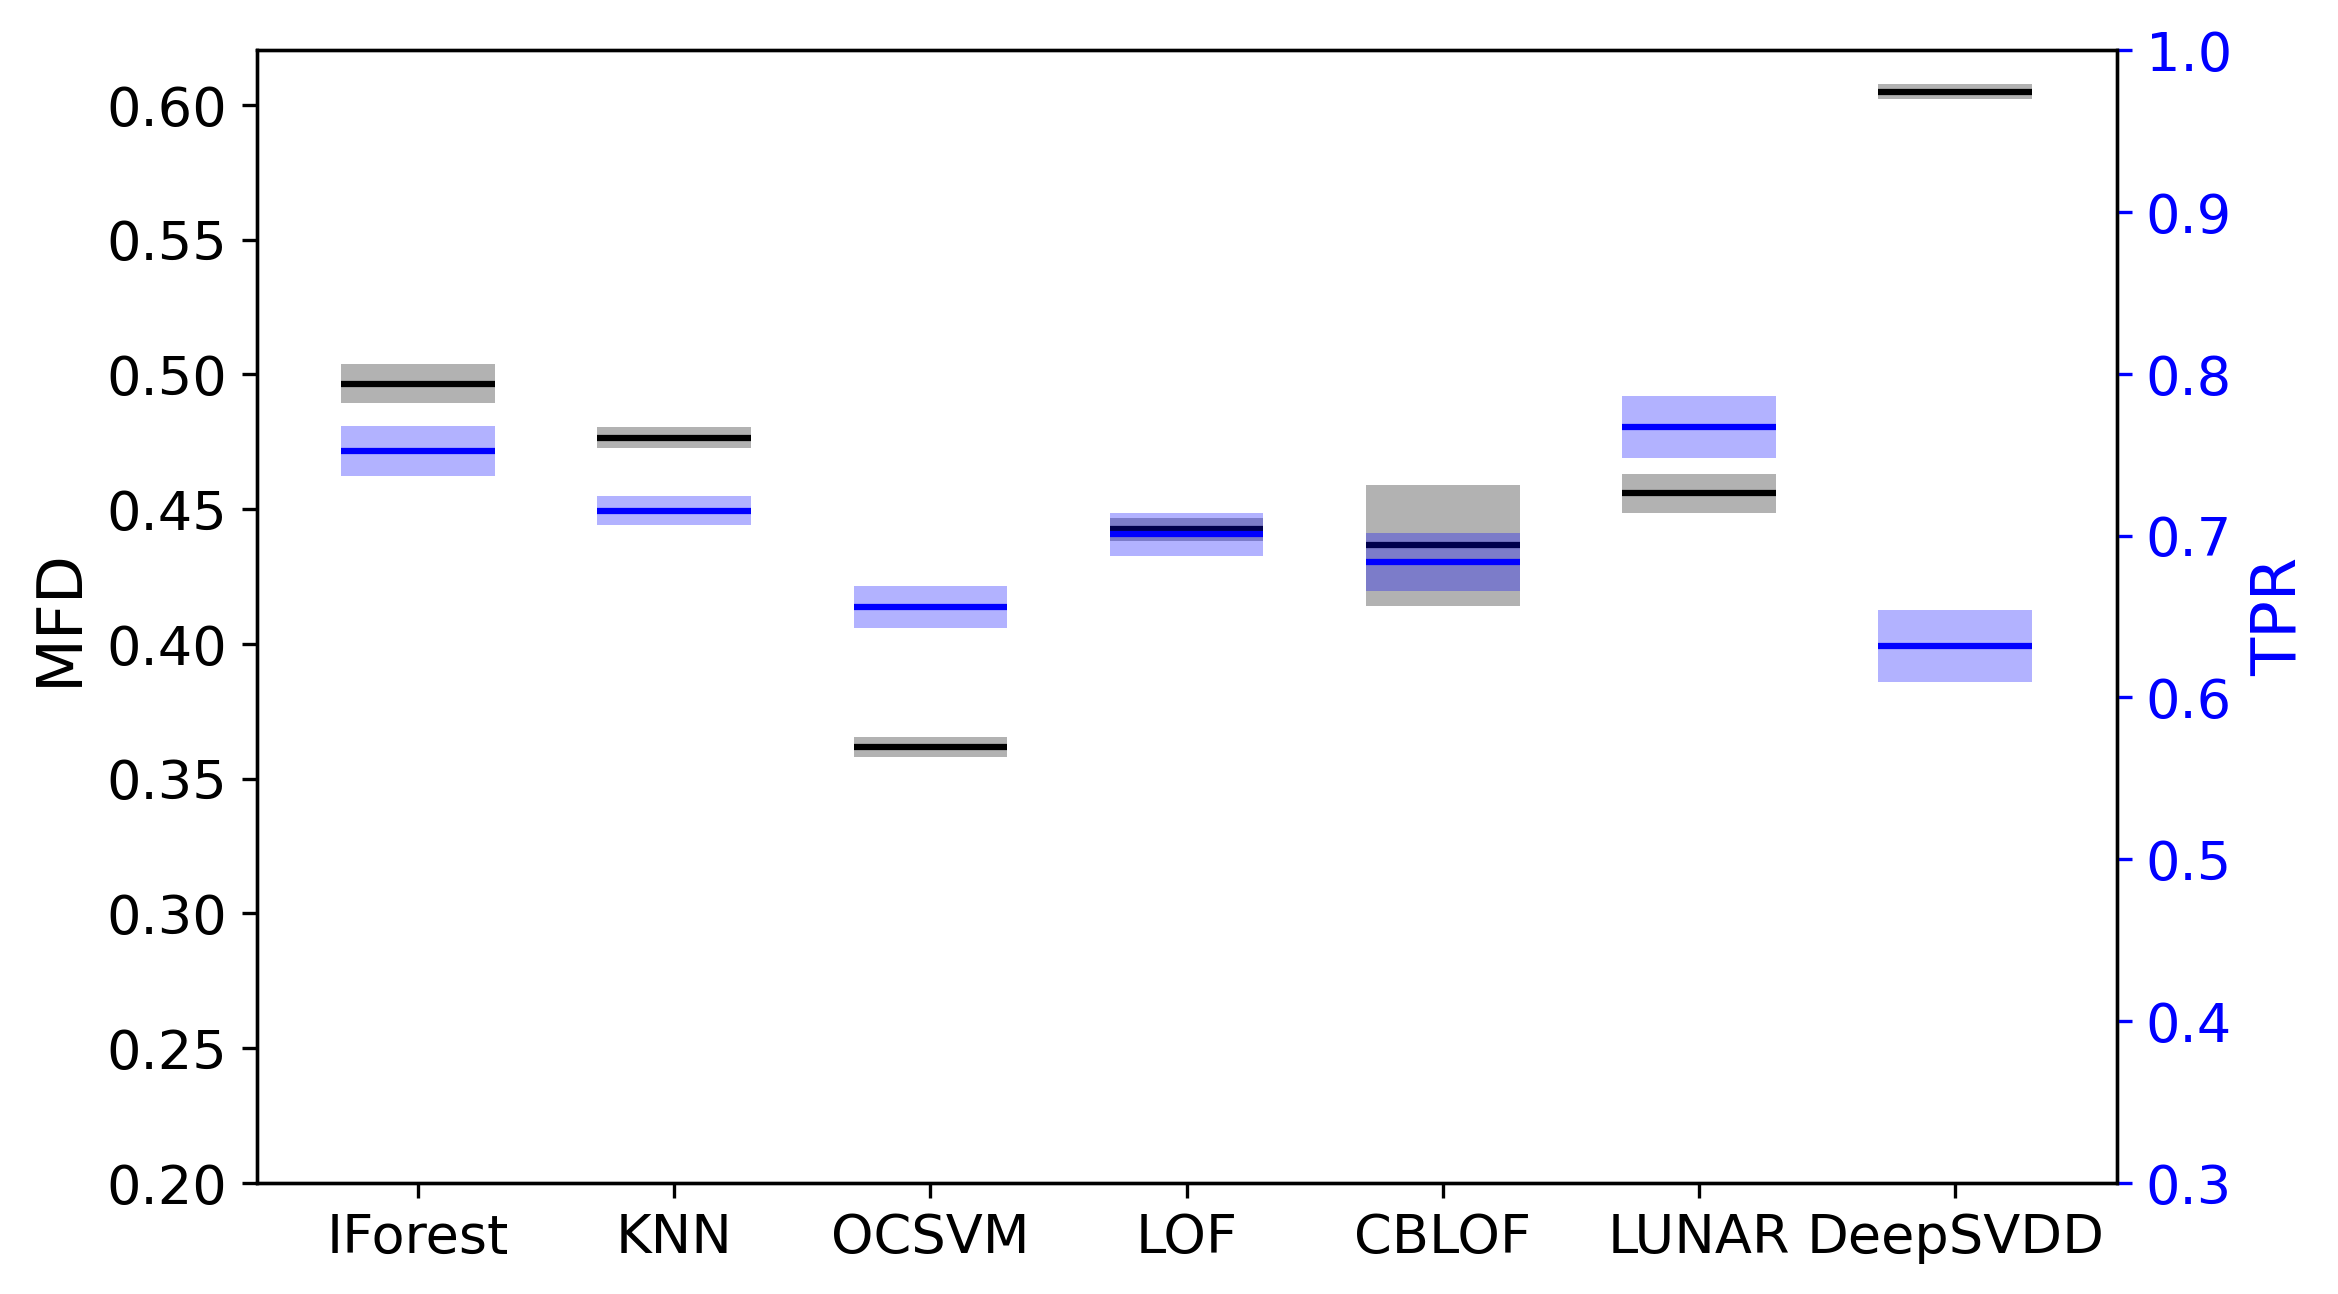

In [20]:
import matplotlib.pyplot as plt

mfd_mean =[]
mfd_std=[]

for clf_name in clf_name_list:
    mfd_mean.append(np.mean(locals()['mfd_'+clf_name]))
    mfd_std.append(np.std(locals()['mfd_'+clf_name]))
    
tp_mean =[]
tp_std=[]

for clf_name in clf_name_list:
    tp_mean.append(np.mean(locals()['tp_'+clf_name]))
    tp_std.append(np.std(locals()['tp_'+clf_name]))
    
fig, ax1 = plt.subplots(figsize=(8,5), dpi=300)     
color = 'black'

fontsize = 13

for i in np.arange(len(clf_name_list)):
    ax1.hlines(y=mfd_mean[i], xmin=i-0.3, xmax=i+0.3, color="black")
    ax1.bar(i, height=mfd_std[i]*2, bottom=mfd_mean[i]-mfd_std[i], alpha=0.3, width=0.6, color=color)

ax1.set_ylabel('MFD', color=color, fontsize=15)
y_ticks = np.arange(0.2, 0.61, 0.05)
ax1.set_yticks(y_ticks, color=color)
ax1.tick_params(axis='y', colors=color, labelsize=fontsize)
ax1.tick_params(axis='x', labelsize=fontsize)

ax2 = ax1.twinx()
color='blue'
for i in np.arange(len(clf_name_list)):
    ax2.hlines(y=tp_mean[i], xmin=i-0.3, xmax=i+0.3, color=color)
    ax2.bar(i, height=tp_std[i]*2, bottom=tp_mean[i]-tp_std[i], alpha=0.3, width=0.6, color=color)

ax2.set_ylabel('TPR', color=color, fontsize=15)
y_ticks = np.arange(0.3, 1.1, 0.1)
ax2.set_yticks(y_ticks, color=color)
ax2.tick_params(axis='y', colors=color, labelsize=fontsize)

plt.xticks(np.arange(len(clf_name_list)), clf_name_list)
plt.tick_params(axis='x', which='major', labelsize=20)
plt.show()

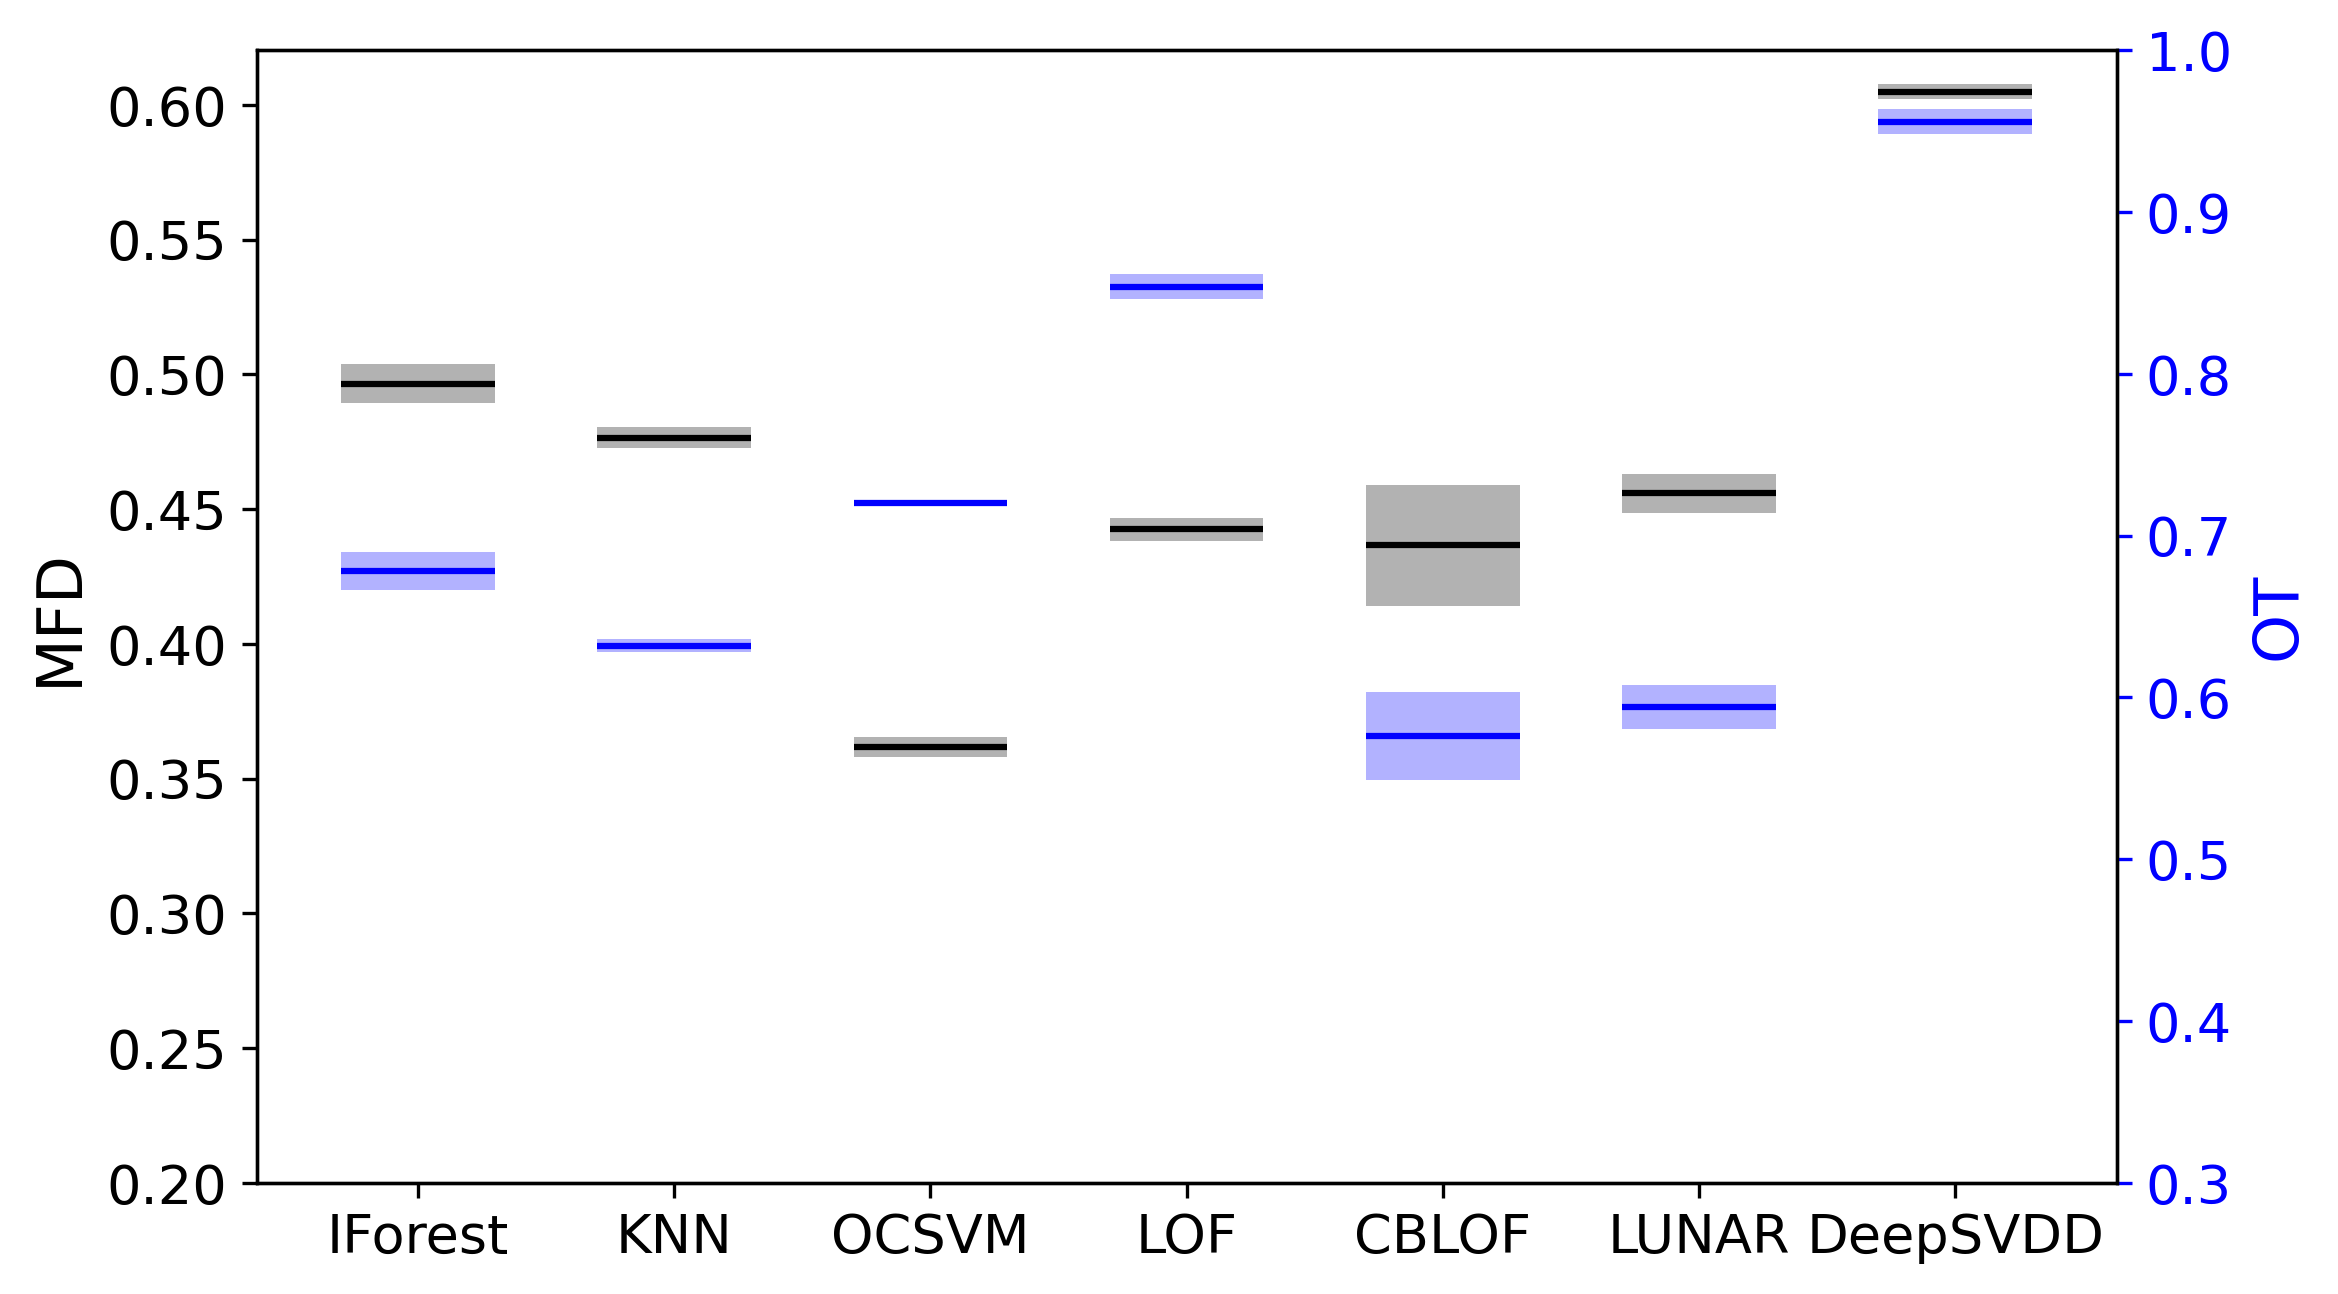

In [21]:
import matplotlib.pyplot as plt

mfd_mean =[]
mfd_std=[]

for clf_name in clf_name_list:
    mfd_mean.append(np.mean(locals()['mfd_'+clf_name]))
    mfd_std.append(np.std(locals()['mfd_'+clf_name]))
    
ot_mean =[]
ot_std=[]

for clf_name in clf_name_list:
    ot_mean.append(np.mean(locals()['ot_'+clf_name]))
    ot_std.append(np.std(locals()['ot_'+clf_name]))
    
fig, ax1 = plt.subplots(figsize=(8,5), dpi=300)     
color = 'black'

fontsize = 13

for i in np.arange(len(clf_name_list)):
    ax1.hlines(y=mfd_mean[i], xmin=i-0.3, xmax=i+0.3, color="black")
    ax1.bar(i, height=mfd_std[i]*2, bottom=mfd_mean[i]-mfd_std[i], alpha=0.3, width=0.6, color=color)

ax1.set_ylabel('MFD', color=color, fontsize=15)
y_ticks = np.arange(0.2, 0.61, 0.05)
ax1.set_yticks(y_ticks, color=color)
ax1.tick_params(axis='y', colors=color, labelsize=fontsize)
ax1.tick_params(axis='x', labelsize=fontsize)

ax2 = ax1.twinx()
color='blue'
for i in np.arange(len(clf_name_list)):
    ax2.hlines(y=ot_mean[i], xmin=i-0.3, xmax=i+0.3, color=color)
    ax2.bar(i, height=ot_std[i]*2, bottom=ot_mean[i]-ot_std[i], alpha=0.3, width=0.6, color=color)

ax2.set_ylabel('OT', color=color, fontsize=15)
y_ticks = np.arange(0.3, 1.1, 0.1)
ax2.set_yticks(y_ticks, color=color)
ax2.tick_params(axis='y', colors=color, labelsize=fontsize)

plt.xticks(np.arange(len(clf_name_list)), clf_name_list)
plt.show()

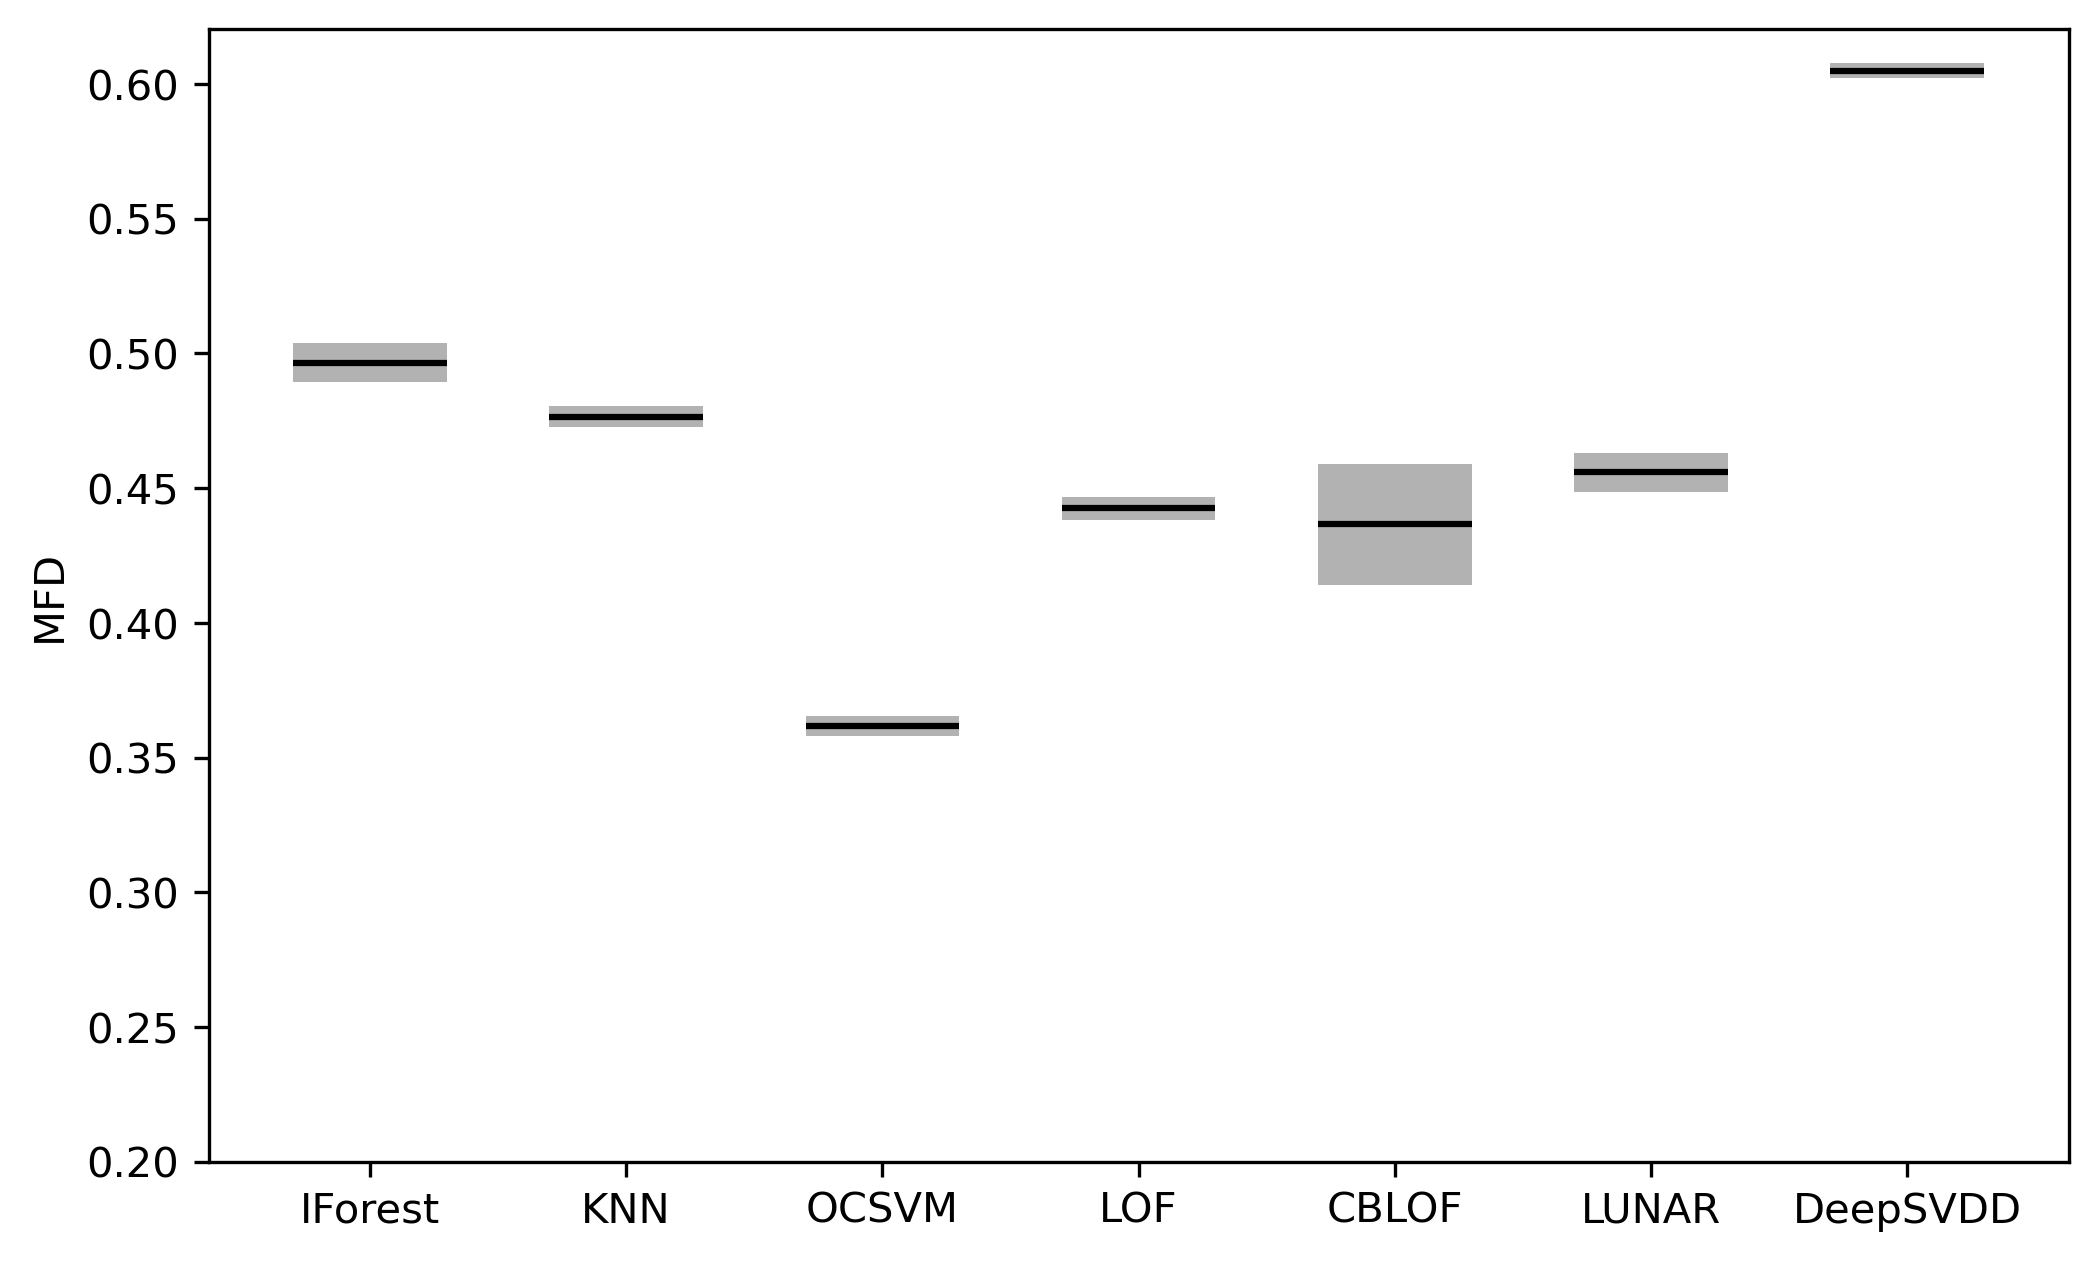

In [22]:
import matplotlib.pyplot as plt

mfd_mean =[]
mfd_std=[]

for clf_name in clf_name_list:
    mfd_mean.append(np.mean(locals()['mfd_'+clf_name]))
    mfd_std.append(np.std(locals()['mfd_'+clf_name]))
    
tp_mean =[]
tp_std=[]

for clf_name in clf_name_list:
    tp_mean.append(np.mean(locals()['tp_'+clf_name]))
    tp_std.append(np.std(locals()['tp_'+clf_name]))
    
fig, ax1 = plt.subplots(figsize=(8,5), dpi=300)     
color = 'black'

for i in np.arange(len(clf_name_list)):
    ax1.hlines(y=mfd_mean[i], xmin=i-0.3, xmax=i+0.3, color="black")
    ax1.bar(i, height=mfd_std[i]*2, bottom=mfd_mean[i]-mfd_std[i], alpha=0.3, width=0.6, color=color)

ax1.set_ylabel('MFD', color=color)
y_ticks = np.arange(0.2, 0.61, 0.05)
ax1.set_yticks(y_ticks, color=color)
ax1.tick_params(axis='y', colors=color)

plt.xticks(np.arange(len(clf_name_list)), clf_name_list)
plt.show()